# Yearly Analysis for the Rainfall Data

In [712]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
import seaborn as sns

### Reading the file

In [713]:
df = pd.read_csv("Sub_Division_IMD_2017.csv")


### Collected Data for Andaman for all years

In [714]:
new_df = df.loc[:111,['YEAR','ANNUAL']].copy()

### Converted into Date Time object and filling the missing years in between the Dataset and making the date as the index

In [715]:
new_df['YEAR'] = pd.to_datetime(new_df['YEAR'], format='%Y')
s=new_df.iloc[0]['YEAR']
e=new_df.iloc[-1]['YEAR']
new_df = new_df.set_index('YEAR')

In [716]:
new_date_range = pd.date_range(start=s, end=e, freq="AS")
new_df=new_df.reindex(new_date_range,fill_value=np.nan)

### Linear Interpolating the missing values and plotting the graph

<AxesSubplot:>

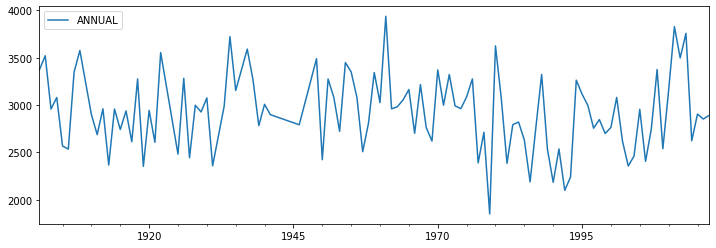

In [717]:
new_df = new_df.assign(ANNUAL_PRICE_Interpolation = new_df['ANNUAL'].interpolate(method='linear'))
new_df=new_df.drop('ANNUAL', axis=1)
new_df = new_df.rename(columns={'ANNUAL_PRICE_Interpolation': 'ANNUAL'})
new_df.plot(figsize=(12,4))

## Detetection of outliers

/home/rahul/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


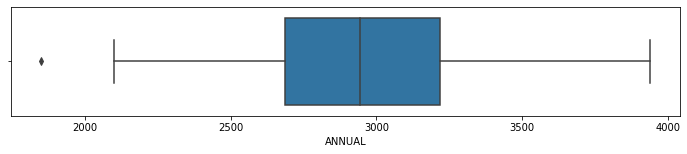

In [718]:
fig = plt.subplots(figsize=(12,2))
ax = sns.boxplot(new_df['ANNUAL'], whis=1.5)

If we see the graph only one outlier exist for whis = 1.5 and  we didn't remove it because there might be one year which has very less rainfall as it may signify something in the analysis

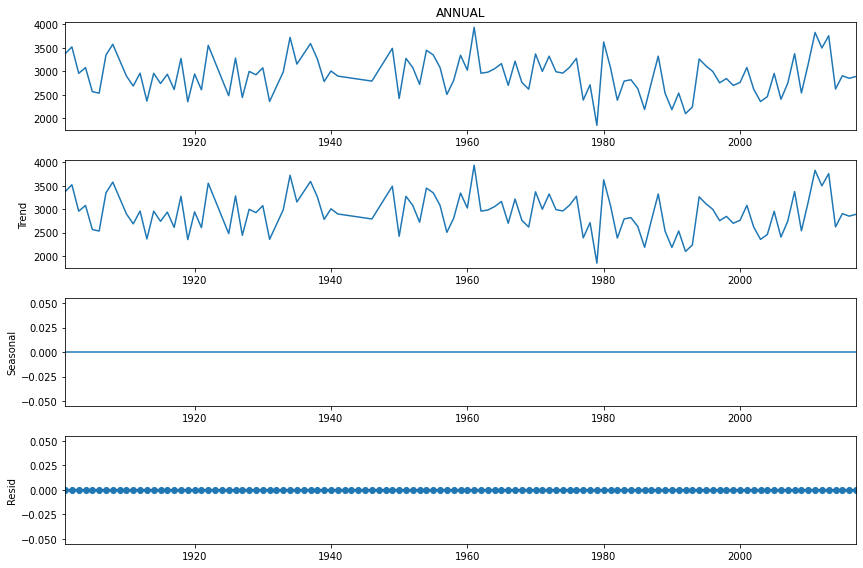

In [719]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 12,8
decomposition = sm.tsa.seasonal_decompose(new_df['ANNUAL'], model='additive')
fig = decomposition.plot()
plt.show()

**Observations** : We have done the Decomposition, we have observed more trend part and there is no seasonality part in the time series because as it is a annual rainfall data there will be no seasonality part because rain fall data may have seasonality in months

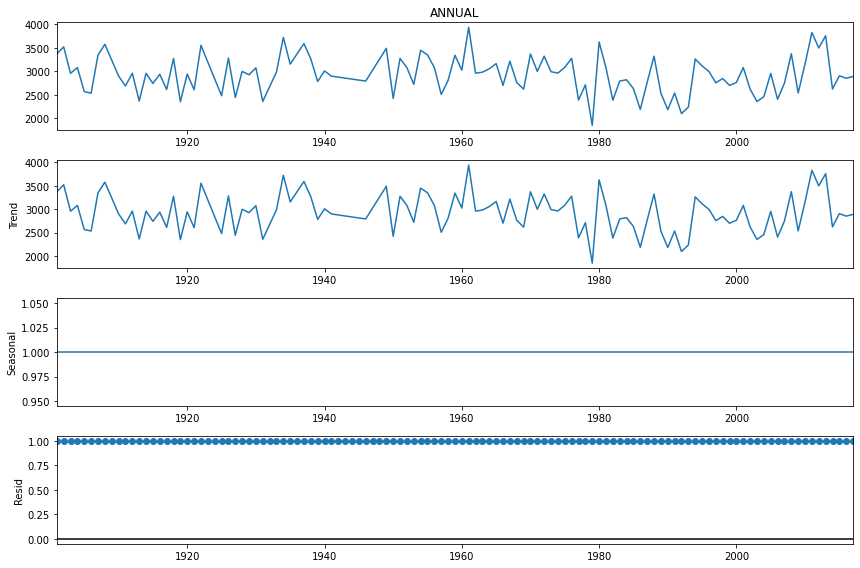

In [720]:
decomposition = sm.tsa.seasonal_decompose(new_df['ANNUAL'], model='multiplicative')
fig = decomposition.plot()
plt.show()

## Splitting the Dataset

In [721]:
train_len = 94
train = new_df[0:train_len]
test = new_df[train_len:]

### Applied simple moving average for the Dataset

In [722]:
y_hat_sma = new_df.copy()
ma_window = 12
y_hat_sma['sma_forecast'] = new_df['ANNUAL'].rolling(ma_window).mean()
y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]

### Plotting the graph for the simple moving average fit for the dataset

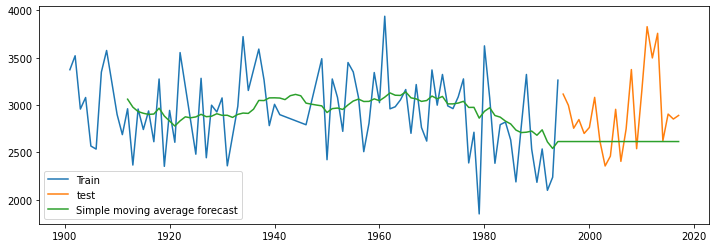

In [725]:
plt.figure(figsize=(12,4))
plt.plot(train['ANNUAL'], label='Train')
plt.plot(test['ANNUAL'], label='test')
plt.plot(y_hat_sma['sma_forecast'], label='Simple moving average forecast')
plt.legend(loc='best')
plt.show()

As we see it is not the best fit for that Dataset

### Exponential Smoothing Family

In [726]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [727]:
model = SimpleExpSmoothing(train['ANNUAL'])
model_fit = model.fit(smoothing_level = 0.3, optimized=False)
y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] = model_fit.forecast(23)

Forecasting for the test data using tha above fitted model

In [728]:
rmse = np.sqrt(mean_squared_error(test['ANNUAL'], y_hat_ses['ses_forecast'])).round(2)
print("Rmse for the above model is: ",rmse)

Rmse for the above model is:  481.41


In [729]:
mape = round(np.mean(np.abs((test['ANNUAL'] - y_hat_ses['ses_forecast'])/test['ANNUAL'])*100),2)
print("Mape for the above model is: ",mape)

Mape for the above model is:  11.23


In [730]:
results = pd.DataFrame({'Method':['Simple exponential smoothing forcast'], 'RMSE':[rmse], 'MAPE':[mape]})

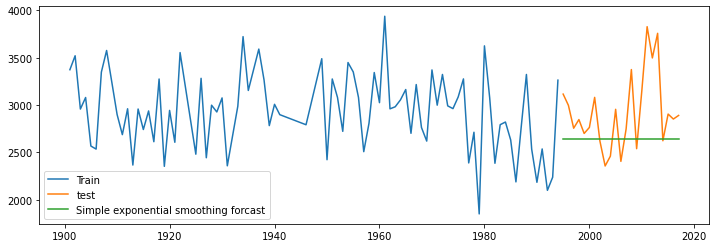

In [731]:
plt.figure(figsize=(12,4))
plt.plot(train['ANNUAL'], label='Train')
plt.plot(test['ANNUAL'], label='test')
plt.plot(y_hat_ses['ses_forecast'], label='Simple exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

## Holts exponential smoothing
### Captures both Level and Trend

In [732]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [733]:
model = ExponentialSmoothing(np.asarray(train['ANNUAL']), seasonal_periods = 12, trend='additive', seasonal=None)
model_fit = model.fit(smoothing_level = 0.3, smoothing_slope = 0.01, optimized=False)
y_hat_holt = test.copy()
y_hat_holt['holt_forecast'] = model_fit.forecast(23)

/tmp/ipykernel_11611/3153402238.py:2: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  model_fit = model.fit(smoothing_level = 0.3, smoothing_slope = 0.01, optimized=False)


In [734]:
rmse = np.sqrt(mean_squared_error(test['ANNUAL'], y_hat_holt['holt_forecast'])).round(2)
print("Rmse for the above model is: ",rmse)

Rmse for the above model is:  591.84


In [735]:
mape = round(np.mean(np.abs((test['ANNUAL'] - y_hat_holt['holt_forecast'])/test['ANNUAL'])*100),2)
print("Mape for the above model is: ",mape)

Mape for the above model is:  14.3


In [736]:
results = results.append({'Method':'Holt\'s Exponential smoothing', 'RMSE':rmse, 'MAPE':mape}, ignore_index=True)

/tmp/ipykernel_11611/853250841.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Method':'Holt\'s Exponential smoothing', 'RMSE':rmse, 'MAPE':mape}, ignore_index=True)


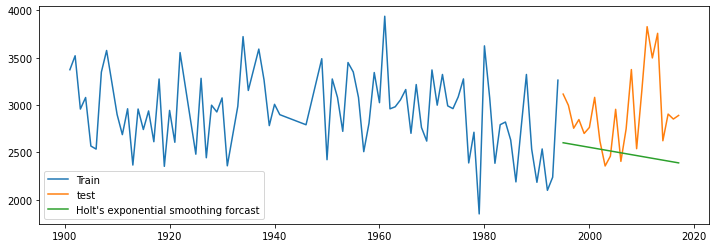

In [737]:
plt.figure(figsize=(12,4))
plt.plot(train['ANNUAL'], label='Train')
plt.plot(test['ANNUAL'], label='test')
plt.plot(y_hat_holt['holt_forecast'], label='Holt\'s exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

### As we see in the graph it doesn't fit the Data

In [738]:
y_hat_hwa = test.copy()

## Captures seasonality also

In [739]:
model = ExponentialSmoothing(np.asarray(train['ANNUAL']), seasonal_periods = 12, trend='additive', seasonal='additive')
model_fit = model.fit(optimized=True)

Training the model using addititve seasonality

In [740]:
model_fit.params

{'smoothing_level': 0.10837908412524223,
 'smoothing_trend': 0.10573938491981884,
 'smoothing_seasonal': 0.00011082717391382257,
 'damping_trend': nan,
 'initial_level': 3027.6111845533096,
 'initial_trend': -16.016866275645192,
 'initial_seasons': array([  74.86610418,   -5.97331523, -112.41563749,  100.16815761,
        -197.35060865,   45.63916045, -223.50027964,   30.0295444 ,
        -107.61330575,  229.8206808 ,   55.41393914,  127.8575031 ]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [741]:
y_hat_hwa['hwa_forecast'] = model_fit.forecast(23)

Forecasted for the test data

In [742]:
rmse = np.sqrt(mean_squared_error(test['ANNUAL'], y_hat_hwa['hwa_forecast'])).round(2)
print("Rmse for the above model is: ",rmse)

Rmse for the above model is:  856.61


In [743]:
mape = round(np.mean(np.abs((test['ANNUAL'] - y_hat_hwa['hwa_forecast'])/test['ANNUAL'])*100),2)
print("Mape for the above model is: ",mape)

Mape for the above model is:  22.5


In [744]:
results = results.append({'Method':'Holt\'s Winter additive method', 'RMSE':rmse, 'MAPE':mape}, ignore_index=True)

/tmp/ipykernel_11611/358243232.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Method':'Holt\'s Winter additive method', 'RMSE':rmse, 'MAPE':mape}, ignore_index=True)


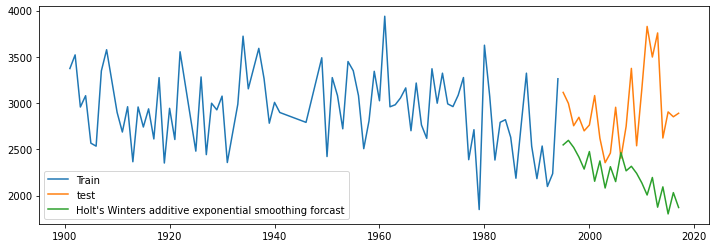

In [745]:
plt.figure(figsize=(12,4))
plt.plot(train['ANNUAL'], label='Train')
plt.plot(test['ANNUAL'], label='test')
plt.plot(y_hat_hwa['hwa_forecast'], label='Holt\'s Winters additive exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

## Multiplicative method

In [746]:
y_hat_hwm = test.copy()

In [747]:
model = ExponentialSmoothing(np.asarray(train['ANNUAL']), seasonal_periods = 12, trend='add', seasonal='mul')
model_fit = model.fit(optimized=True)

Using multiplicative seasonality model is trained

In [748]:
model_fit.params

{'smoothing_level': 0.11107148027844298,
 'smoothing_trend': 0.09873020041421028,
 'smoothing_seasonal': 0.00010004183506269915,
 'damping_trend': nan,
 'initial_level': 3010.5437783564576,
 'initial_trend': -19.478087727330248,
 'initial_seasons': array([1.15860667, 1.08282978, 1.06623156, 1.14318152, 1.00631306,
        1.08270157, 1.02602863, 1.10304329, 1.03180815, 1.14943845,
        1.11587951, 1.14158996]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [749]:
y_hat_hwm['hwm_forecast'] = model_fit.forecast(23)

In [750]:
rmse = np.sqrt(mean_squared_error(test['ANNUAL'], y_hat_hwm['hwm_forecast'])).round(2)
print("Rmse for the above model is: ",rmse)

Rmse for the above model is:  822.25


In [751]:
mape = round(np.mean(np.abs((test['ANNUAL'] - y_hat_hwm['hwm_forecast'])/test['ANNUAL'])*100),2)
print("Mape for the above model is: ",mape)

Mape for the above model is:  21.25


In [752]:
results = results.append({'Method':'Holt\'s Winter multiplicative method', 'RMSE':rmse, 'MAPE':mape}, ignore_index=True)

/tmp/ipykernel_11611/1256001976.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Method':'Holt\'s Winter multiplicative method', 'RMSE':rmse, 'MAPE':mape}, ignore_index=True)


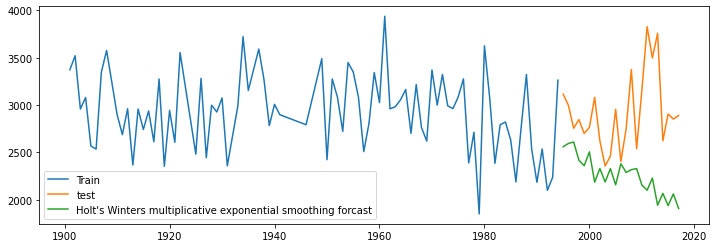

In [753]:
plt.figure(figsize=(12,4))
plt.plot(train['ANNUAL'], label='Train')
plt.plot(test['ANNUAL'], label='test')
plt.plot(y_hat_hwm['hwm_forecast'], label='Holt\'s Winters multiplicative exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

#### As we see in above graphs exponential methods doesn't give better accuracy for the time series so we have tried arima models so before trying arima models we have done stationary test for the time series

## Stationarity Test

Running adfuller test for the time series

In [754]:
from statsmodels.tsa.stattools import adfuller

In [755]:
adf_test = adfuller(new_df['ANNUAL'])
adf_test

(-9.132602987203564,
 2.993936806635922e-15,
 0,
 116,
 {'1%': -3.4880216384691867,
  '5%': -2.8867966864160075,
  '10%': -2.5802408234244947},
 1525.3551075556488)

#### As we see from the above results statistic value is less than critical value so the time series is stationary 

In [756]:
from statsmodels.graphics.tsaplots import plot_acf

### Plotting the acf plots

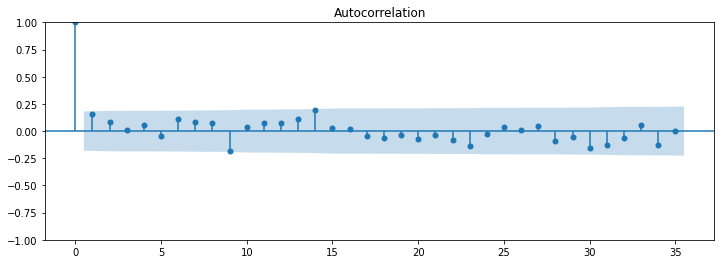

In [757]:
plt.figure(figsize=(12,4))
plot_acf(new_df, ax=plt.gca(), lags=35)
plt.show()

 As we see the above plot there is no much correlation between the lags 

In [758]:
from statsmodels.graphics.tsaplots import plot_pacf

/home/rahul/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


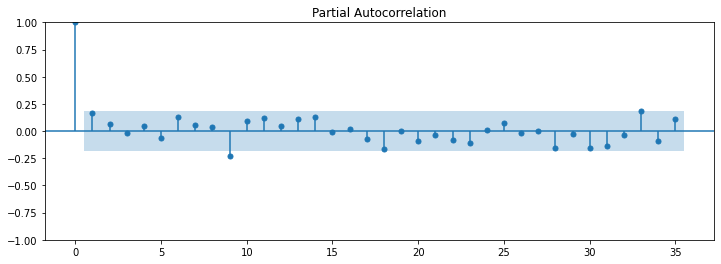

In [759]:
plt.figure(figsize=(12,4))
plot_pacf(new_df, ax=plt.gca(), lags=35)
plt.show()

We can see the partial correlation for lag 9 has significant value

### We have implemented the arima model on the time series

## AR Model

In [760]:
from statsmodels.tsa.arima.model import ARIMA

Using pacf plots , acf plots we have obtained p as 9 , das 0 q as 0 and trained the model

In [761]:
model = ARIMA(train, order=(9,0,0))

In [762]:
model_fit = model.fit()
model_fit.params

const       2935.639814
ar.L1          0.133565
ar.L2          0.033564
ar.L3         -0.023819
ar.L4          0.072388
ar.L5         -0.051318
ar.L6          0.149116
ar.L7          0.117437
ar.L8          0.124942
ar.L9         -0.211832
sigma2    135783.835863
dtype: float64

In [763]:
y_hat_ar = new_df.copy()
y_hat_ar['ar_forecast'] = model_fit.predict(new_df.index.min(), new_df.index.max())

In [765]:
rmse = np.sqrt(mean_squared_error(new_df['ANNUAL'], y_hat_ar['ar_forecast'])).round(2)
print("Rmse for the above model is: ",rmse)

Rmse for the above model is:  373.85


In [766]:
mape = round(np.mean(np.abs((new_df['ANNUAL'] - y_hat_ar['ar_forecast'])/new_df['ANNUAL'])*100),2)
print("Mape for the above model is: ",mape)

Mape for the above model is:  10.34


In [767]:
results = results.append({'Method':'ARIMA method', 'RMSE':rmse, 'MAPE':mape}, ignore_index=True)

/tmp/ipykernel_11611/226885135.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Method':'ARIMA method', 'RMSE':rmse, 'MAPE':mape}, ignore_index=True)


,Method,RMSE,MAPE
0,Simple exponential smoothing forcast,481.41,11.23
1,Holt's Exponential smoothing,591.84,14.30
2,Holt's Winter additive method,856.61,22.50
3,Holt's Winter multiplicative method,822.25,21.25
4,ARIMA method,373.85,10.34


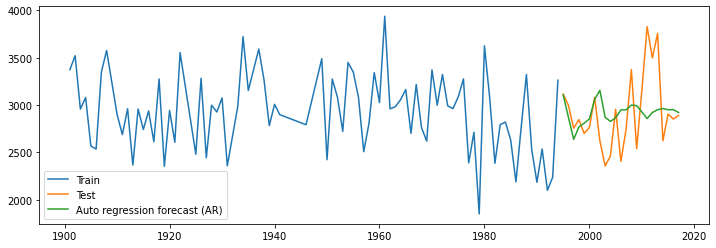

In [768]:
plt.figure(figsize=(12,4))
plt.plot(train['ANNUAL'], label='Train')
plt.plot(test['ANNUAL'], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='Auto regression forecast (AR)')
plt.legend(loc='best')
plt.show()

We have obtained better accuracy for the arima model

We have implemented the sarimax model for the time series

In [769]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [770]:
model = SARIMAX(new_df, order=(1,0,1), seasonal_order=(1,1,1,12))

In [771]:
model_fit = model.fit()

/home/rahul/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/rahul/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.80466D+00    |proj g|=  9.35194D-02

At iterate    5    f=  6.78112D+00    |proj g|=  1.69000D-02

At iterate   10    f=  6.78037D+00    |proj g|=  1.51217D-03

At iterate   15    f=  6.77998D+00    |proj g|=  1.55549D-03

At iterate   20    f=  6.77914D+00    |proj g|=  1.81305D-02

At iterate   25    f=  6.74463D+00    |proj g|=  1.12464D-02

At iterate   30    f=  6.74440D+00    |proj g|=  2.49918D-03

At iterate   35    f=  6.74430D+00    |proj g|=  2.59570D-04

At iterate   40    f=  6.74420D+00    |proj g|=  7.92269D-04

At iterate   45    f=  6.74414D+00    |proj g|=  8.57014D-04

At iterate   50    f=  6.74412D+00    |proj g|=  2.80980D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/rahul/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [772]:
y_hat_sarima = new_df.copy()
y_hat_sarima['sarima_forecast'] = model_fit.predict(new_df.index.min(), new_df.index.max())

In [774]:
rmse = np.sqrt(mean_squared_error(new_df['ANNUAL'], y_hat_sarima['sarima_forecast'])).round(2)
print("Rmse for the above model is: ",rmse)

Rmse for the above model is:  1072.74


In [775]:
mape = round(np.mean(np.abs((new_df['ANNUAL'] - y_hat_sarima['sarima_forecast'])/new_df['ANNUAL'])*100),2)
print("Mape for the above model is: ",mape)

Mape for the above model is:  21.4


In [776]:
results = results.append({'Method':'Sarima model', 'RMSE':rmse, 'MAPE':mape}, ignore_index=True)

/tmp/ipykernel_11611/2664009873.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Method':'Sarima model', 'RMSE':rmse, 'MAPE':mape}, ignore_index=True)


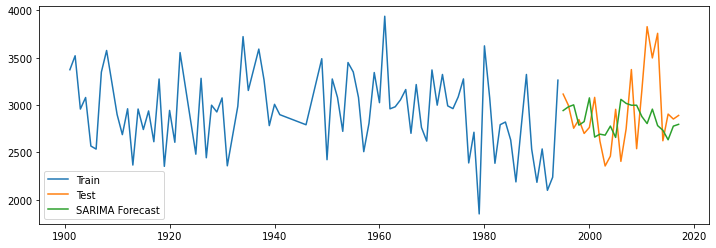

In [777]:
plt.figure(figsize=(12,4))
plt.plot(train['ANNUAL'], label='Train')
plt.plot(test['ANNUAL'], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():], label='SARIMA Forecast')
plt.legend(loc='best')
plt.show()

In [778]:
results

,Method,RMSE,MAPE
0,Simple exponential smoothing forcast,481.41,11.23
1,Holt's Exponential smoothing,591.84,14.30
2,Holt's Winter additive method,856.61,22.50
3,Holt's Winter multiplicative method,822.25,21.25
4,ARIMA method,373.85,10.34
5,Sarima model,1072.74,21.40


Final observations : By observing the Data, it is stationary so we have obtained better accuracy with the arima models than the exponential methods and we have obtained Rmse as 373 and mape as 10 .It is annual Rainfall Data so we can't expect better prediction models beacuse it might be random points complex to model those process.So we will suggest Arima model for the Annual Rainfall Data